In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix, PrecisionRecallDisplay

In [2]:
df = pd.read_csv("creditcard.csv")

Задача состоит в том, чтобы **отделить мошеннические операции (класс 1) от от обычных (класс 0)**

Основные нюансы задачи:

1) Смысл фичей `V1` - `V28` не определить, поэтому никаких **манипуляций** с ними **произвести не можем**;
   
3) По п.1 также **не провести полноценный feature engineering**. Работать можно только с `Time` и `Amount`, но даст ли это какой-то прирост?..

4) **Определение выбросов** для большинства фичей в этой задаче **не представляется возможным** (см. п. 1), если даже и есть какие-то аномальные значения, то их не отделить - из-за этого **можно сразу откинуть использование SVM** (ну ещё и потому что данных много);

5) Вопрос ещё в том, какую метрику здесь следует рассматривать:
    - **accuracy** сразу **мимо**, т.к. классы несбалансированы (спойлер);
    - **precision и recall нужно оба держать на высоком уровне**: нужно уметь классифицировать правильно и мошенническую операцию, и обычную - как вариант **рассматривать какую-нибудь f-меру, но тогда нужно будет заниматься сэмплированием**;
    - **ROC-AUC** выглядит неплохо, но он всё-таки **завязан на recall'e, который у нас и так будет высоким**;
    - **PR-AUC выглядит неплохо**, даже не всяких "но" - были бы проблемы, будь данных слишком мало, но датасет у нас вполне приличный
  
      Думаю, конкретно для этой задачи будет важнее отделять все мошеннические операции, чтобы банк не терял деньги, так что  всё-таки следует думать между PR-AUC и F2-мерой

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Разведочный анализ данных

Среди типов данных **только числовые значения**, дополнительные кодировки не потребуются

In [4]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

К тому же пропусков в данных нет

In [5]:
df.isna().sum().sum()

0

Первая встретившаяся проблема - **наличие дубликатов**. Избавимся от них

In [6]:
df_wo_dupl = df.drop_duplicates()

print(f"В записях было {len(df) - len(df_wo_dupl)} дубликатов")

В записях было 1081 дубликатов


Также в классах присутствует **большой дисбаланс** - это отразится на применяемых подходах

In [7]:
print(f"В датафрейме всего {round(df_wo_dupl.Class.value_counts()[1] / df_wo_dupl.shape[0] * 100, 2)}% мошеннических транзакций")

В датафрейме всего 0.17% мошеннических транзакций


Фичи `V1` -`V28` почти **не коррелируют** между собой, поскольку они были получены путём понижения размерности данных, PCA

При этом `Time` вообще **не влияет** на целевую переменную

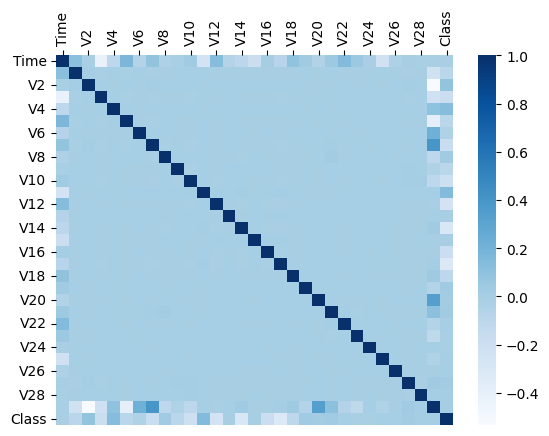

In [8]:
g = sns.heatmap(df_wo_dupl.corr(), cmap="Blues")
g.xaxis.set_ticks_position('top')
g.xaxis.set_tick_params(rotation=90) 

# Визуализация данных

Строить pairplot для всех фичей, даже для части датафрейма в данном случае **очень затратно**, поэтому отстроена только часть графиков

Что плохо - в данных **нелинейные зависимости**

Что хорошо - визуально мошеннечиские операции можно отделить от других операций, **есть надежда на хороший результат при использовании нелинейных моделей**

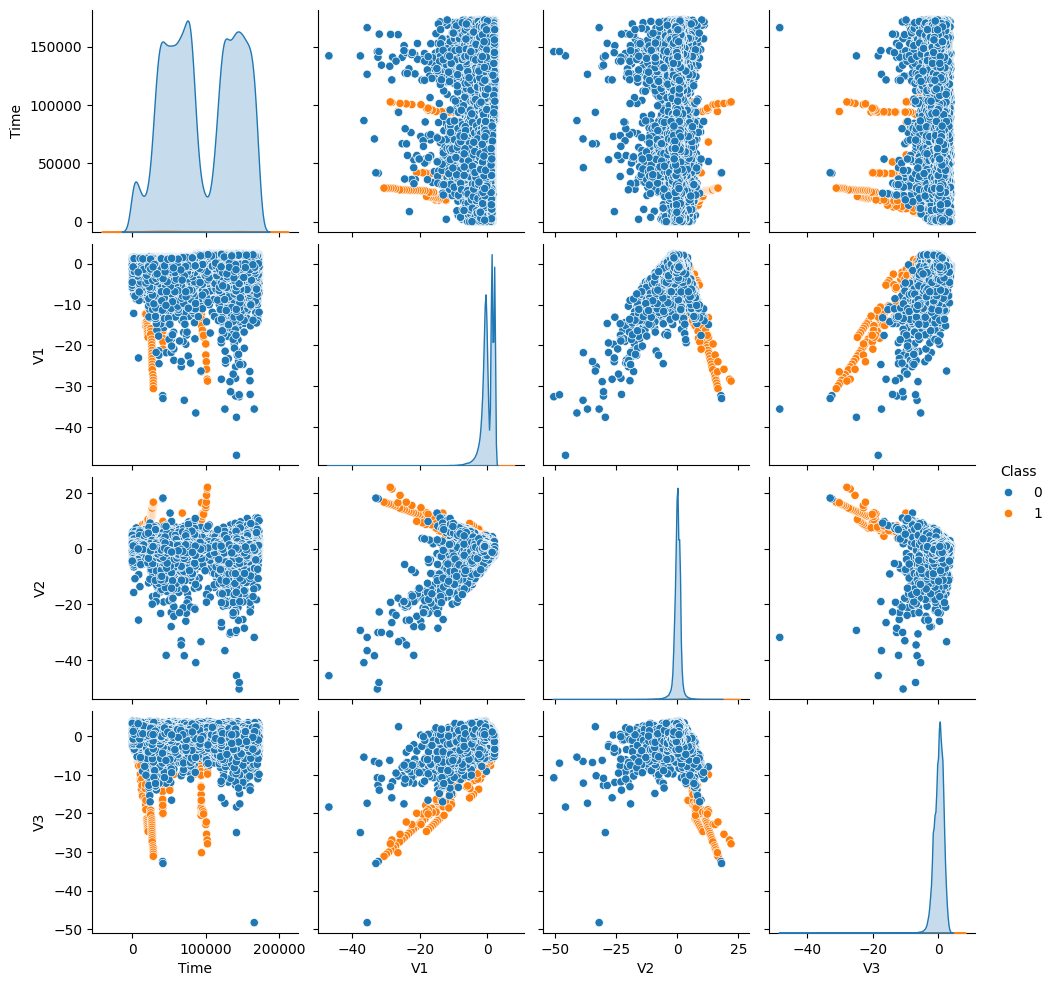

In [9]:
frames = [df_wo_dupl[df_wo_dupl.Class == 1], df_wo_dupl[df_wo_dupl.Class == 0].sample(frac=1).iloc[0:int(1e5), :]]
df_wo_dupl = pd.concat(frames, ignore_index=True)

frames = [df_wo_dupl.iloc[:, 0:4], df_wo_dupl.iloc[:, -1:]]
df_wo_dupl = pd.concat(frames, axis=1, join='inner')

sns.pairplot(data=df_wo_dupl, hue='Class')

# Выбор модели

Разделим датасет на тренировочную и тестовую выборки с гиперпараметром *stratify*, чтобы **сохранить процентное соотношение классов**

In [10]:
X = df.drop(['Class'], axis=1)
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

print(f"В тренировочной выборке всего {round(y_train.value_counts()[1] / y_train.shape[0] * 100, 2)}% мошеннических транзакций")
print(f"В тестовой выборке всего {round(y_test.value_counts()[1] / y_test.shape[0] * 100, 2)}% мошеннических транзакций")

В тренировочной выборке всего 0.17% мошеннических транзакций
В тестовой выборке всего 0.17% мошеннических транзакций


**Cтандартизируем данные** перед применением модели

In [11]:
ss = StandardScaler()
ss.fit(X_train)

X_train_ss = pd.DataFrame(data=ss.transform(X_train), columns=ss.get_feature_names_out())
X_test_ss = pd.DataFrame(data=ss.transform(X_test), columns=ss.get_feature_names_out())


Первая идея, основанная на принципе наименьшего действия - использовать **логистическую регрессию**

В ней в качестве функционала ошибки выступает LogLoss и **перебалансировкой заниматься** не только **не нужно** (ура), но **и нельзя**, потому что решение будет неоткалиброванным

In [12]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train_ss, y_train)
y_pred = lr.predict(X_test_ss)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.06682134570765662, 0.8888888888888888)

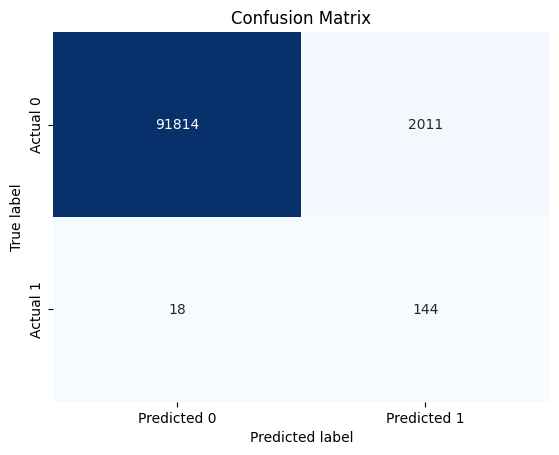

In [13]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Сразу было понятно, что recall будет высоким, но по precision результат, конечно, удручающий...

Всё-таки придётся использовать нелинейные модели. Можно, конечно, раскачиваться от деревьев к лесу, но мне кажется, мы на пути скорее переобучимся, поэтому можно сразу стрельнуть **кэтбустом**. 

Мало того, что эта **модель нелинейная** (а исходя из данных, такую использовать и надо), так она ещё и сама по себе даёт **хорошие результаты даже без подбора гиперпараметров**

In [14]:
cb = CatBoostClassifier(verbose=False)

cb.fit(X_train_ss, y_train)
y_pred = cb.predict(X_test_ss)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.9603174603174603, 0.7469135802469136)

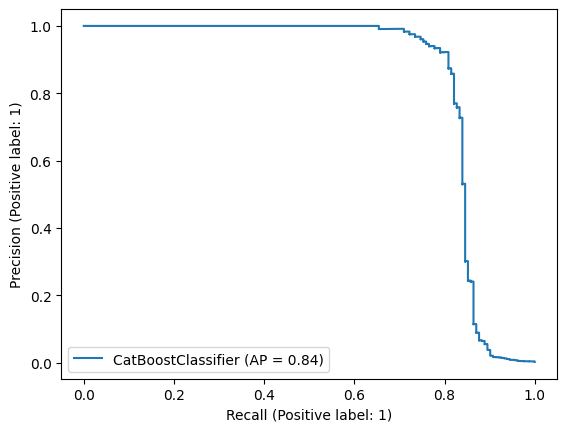

In [15]:
precision, recall, thr = precision_recall_curve(y_test, cb.predict_proba(X_test)[:, 1])

PrecisionRecallDisplay.from_estimator(cb, X_test_ss, y_test, name="CatBoostClassifier")

Но теперь уже, конечно, следует заняться **сэмплированием** (насколько мне известно, **пересэмплирование** обычно даёт более хорошие результаты, нежели недосэмплирование, так что попробуем использовать его)

In [16]:
ros = RandomOverSampler(random_state=42)
X_over_ss, y_over = ros.fit_resample(X_train_ss, y_train)

cb = CatBoostClassifier(verbose=False)
cb.fit(X_over_ss, y_over)
y_pred = cb.predict(X_test)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.80625, 0.7962962962962963)

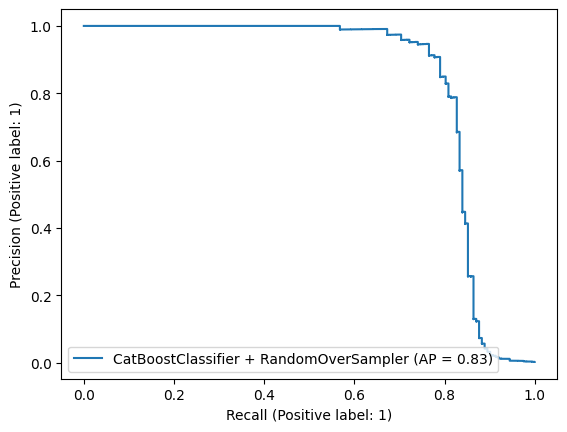

In [17]:
precision, recall, thr = precision_recall_curve(y_test, cb.predict_proba(X_test)[:, 1])

PrecisionRecallDisplay.from_estimator(cb, X_test_ss, y_test, name="CatBoostClassifier + RandomOverSampler")

In [18]:
smote = SMOTE(random_state=42)
X_smote_ss, y_smote = smote.fit_resample(X_train_ss, y_train)

cb_smote = CatBoostClassifier(verbose=False)
cb_smote.fit(X_smote_ss, y_smote)
y_pred = cb_smote.predict(X_test)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.6421568627450981, 0.808641975308642)

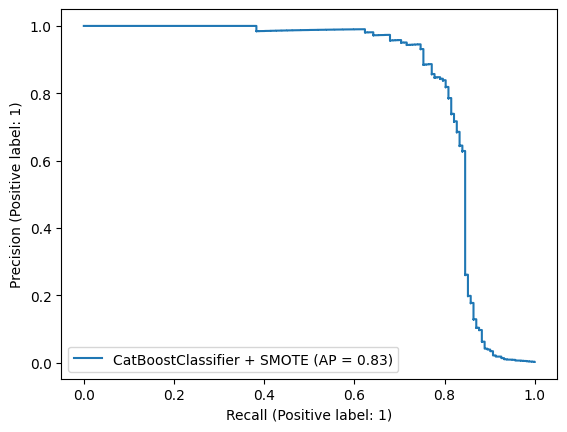

In [19]:
precision, recall, thr = precision_recall_curve(y_test, cb_smote.predict_proba(X_test)[:, 1])
PrecisionRecallDisplay.from_estimator(cb_smote, X_test_ss, y_test, name="CatBoostClassifier + SMOTE")

In [20]:
adasyn = ADASYN(random_state=42)
X_adasyn_ss, y_adasyn = adasyn.fit_resample(X_train_ss, y_train)

cb_adasyn = CatBoostClassifier(verbose=False)
cb_adasyn.fit(X_adasyn_ss, y_adasyn)
y_pred = cb_adasyn.predict(X_test)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.5311203319502075, 0.7901234567901234)

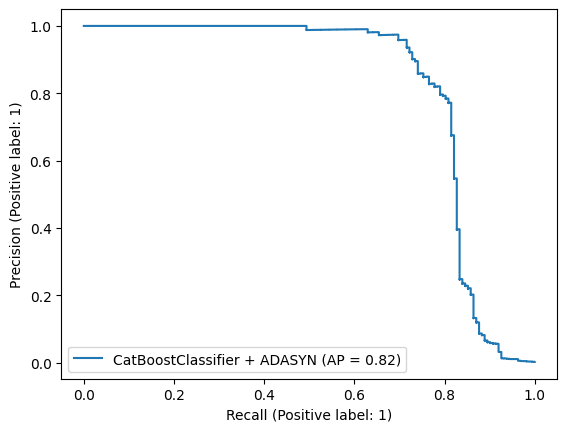

In [21]:
precision, recall, thr = precision_recall_curve(y_test, cb_adasyn.predict_proba(X_test)[:, 1])
PrecisionRecallDisplay.from_estimator(cb_adasyn, X_test_ss, y_test, name="CatBoostClassifier + ADASYN")

В итоге кэтбуст без сэмплирования дал лучший результат